In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Declaramos los siguientes paths que contendran la direccion de nuestro drive en el cual se encuentran los dataframes (tener en cuenta a la hora de probar).

In [2]:
path1 = "/content/gdrive/MyDrive/data_science/challengeK_titanic/gender_submission.csv"
path2 = "/content/gdrive/MyDrive/data_science/challengeK_titanic/test.csv"
path3 = "/content/gdrive/MyDrive/data_science/challengeK_titanic/train.csv"

## Analizando los datos

En este apartado analizaremos los datos. Haciendo graficos y tablas de correlaciones para entender mas los datos.

Para ello tendremos que limpiar los datos tratando los **datos faltantes** y las **variables categoricas**.

In [ ]:
# importamos nuestros datos
df_train = pd.read_csv(path3).sort_values(by=["PassengerId"])
df_test = pd.read_csv(path2).sort_values(by=["PassengerId"])
df_pred = pd.read_csv(path1).sort_values(by=["PassengerId"])

In [ ]:
# dropeamos la unica fila que no tiene valor de ticket
merge= pd.merge(df_test,df_pred,on="PassengerId")
merge.dropna(axis=0, subset=["Fare"], inplace=True)
df_union = pd.concat([df_train, merge], ignore_index=True)


Ahora veamos cuantos datos con valores nulos tenemos.

In [ ]:
merge.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          326
Embarked         0
Survived         0
dtype: int64

Al ver que tenemos un total de 86 filas para la columna `Age` en donde no tenemos datos, al igual que en la columna `Cabin` donde tenemos 327 filas sin informacion, no pareciera que dropear las filas fuera una opcion.

Vamos a tratar los valores nulos con el aprouch **Imputer**.

Con respecto a las variables categoricas como `Sex`, `Cabin`, `Embarked`. Las trataremos con el aprouch **Ordinal Encoder**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

X_train = df_union.copy()

# aplicamos el metodo Ordinal encoder a la columna Cabin y Embarked
X_train[["Embarked", "Cabin", "Sex"]] = ordinal_encoder.fit_transform(X_train[["Embarked", "Cabin","Sex"]])

# Reemplazamos los valores nulos que existen en Cabin por un 0.
for row in range(len(X_train["Cabin"])):
  if pd.isna(X_train["Cabin"][row]):
    X_train["Cabin"][row] = 0

# Reemplazamos los valores nulos que existen en Embarked por un 0.
for row in range(len(X_train["Embarked"])):
  if pd.isna(X_train["Embarked"][row]):
    X_train["Embarked"][row] = 0

# aplicamos el metodo imputed a la columna ages y asi tratar los NULL
from sklearn.impute import SimpleImputer

df_train_plus = X_train[["Age"]]

my_imputer = SimpleImputer()

imputed_age = pd.DataFrame(my_imputer.fit_transform(df_train_plus))

imputed_age.columns = df_train_plus.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# redondeamos la columna Age para no tener tantos decimales
X_train["Age"] = np.round(imputed_age)

X_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1,0,A/5 21171,7.2500,0.0,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1,0,PC 17599,71.2833,106.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0,0,STON/O2. 3101282,7.9250,0.0,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1,0,113803,53.1000,70.0,2.0
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0,0,373450,8.0500,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1305,0,3,"Spector, Mr. Woolf",1.0,30.0,0,0,A.5. 3236,8.0500,0.0,2.0
1304,1306,1,1,"Oliva y Ocana, Dona. Fermina",0.0,39.0,0,0,PC 17758,108.9000,64.0,0.0
1305,1307,0,3,"Saether, Mr. Simon Sivertsen",1.0,38.0,0,0,SOTON/O.Q. 3101262,7.2500,0.0,2.0
1306,1308,0,3,"Ware, Mr. Frederick",1.0,30.0,0,0,359309,8.0500,0.0,2.0


Y ahora podemos observar que hemos limpiado nuestros datos.
Ahora podemos proceder a analizarlos mas facilmente.

In [ ]:
X_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Primero podemos probar haciendo una matris de correlaciones para ver que tan relacionadas estan nuestras variables.

In [ ]:
# como vamos a analizar los supervivientes, vamos a filtrar por superviviente antes de armar la matris de relaciones
X_train_surv = X_train[X_train["Survived"] == 1].copy()

X_train_surv.drop(columns=["PassengerId", "Survived"], inplace=True)

corr = X_train_surv.corr()
corr.style.background_gradient()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
Pclass,1.000000,0.005011,-0.390520,-0.010178,0.032544,-0.554873,-0.525083,0.177417
Sex,0.005011,1.000000,-0.054428,-0.077702,-0.088853,-0.062041,0.044237,0.058270
Age,-0.390520,-0.054428,1.000000,-0.096845,-0.188319,0.227981,0.173201,-0.091630
SibSp,-0.010178,-0.077702,-0.096845,1.000000,0.266711,0.101009,0.047014,0.068186
Parch,0.032544,-0.088853,-0.188319,0.266711,1.000000,0.128744,-0.011800,0.093309
Fare,-0.554873,-0.062041,0.227981,0.101009,0.128744,1.000000,0.254326,-0.248322
Cabin,-0.525083,0.044237,0.173201,0.047014,-0.011800,0.254326,1.000000,-0.058931
Embarked,0.177417,0.058270,-0.091630,0.068186,0.093309,-0.248322,-0.058931,1.000000


Podemos observar que la columna `Cabin` y `Fare` podrian estar un poco relacionadas. Al igual que las columnas `Parch` y `SibSp`.

In [ ]:
df_survived= X_train_surv

total_survived = len(df_survived)

df_survived.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,2.010121,0.220648,29.097166,0.502024,0.506073,48.811497,35.419028,1.344130
std,0.874416,0.415104,13.878883,0.799972,0.888833,68.594401,56.040377,0.879676
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.000000,0.000000,0.000000,11.431275,0.000000,0.000000
50%,2.000000,0.000000,30.000000,0.000000,0.000000,26.000000,0.000000,2.000000
75%,3.000000,0.000000,35.750000,1.000000,1.000000,56.982300,61.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,184.000000,2.000000


Aqui podemos hacer una interpretacion al obtener los datos anteriores.
Vemos que en la columna `Sex` tenemos una media de 0.22 lo cual podria indicar que entre los supervivientes habia mayoria de mujeres.

Por otro lado en la columna `Age` vemos que tenemos una media de 29 anos.

Si analizamos la columna `Fare` la media que obtenemos nos estaria indicando que la mayoria de los supervivientes habia pagado un ticket de 48 usd

Ahora podriamos hacer el siguiente analisis: queremos el porcentaje de personas salvadas cuyo ticket fue menor a la media que obtuvimos y el porcentaje de las personas salvadas cuyo ticket fue mayor a la media que obtuvimos.

In [ ]:
# numero total de pasajeros que pagaron un precio menor que la media
tot_psg_fare_min = len(X_train[X_train["Fare"] < 48.39])

# numero total de pasajeros que pagaron un precio mayor que la media
tot_psg_fare_max = len(X_train[X_train["Fare"] > 48.39])

# numero total de pasajeros de sexo femenino que pagaron un precio menor que la media 
tot_psg_fem_fare_min = len(X_train[(X_train["Fare"] < 48.39) & (X_train["Sex"] == 0)])

# numero total de pasajeros de sexo femenino que pagaron un precio mayor que la media
tot_psg_fem_fare_max = len(X_train[(X_train["Fare"] > 48.39) & (X_train["Sex"] == 0)])

# numero total de pasajeros de sexo masculino que pagaron un precio menor que la media
tot_psg_mas_fare_min = len(X_train[(X_train["Fare"] < 48.39) & (X_train["Sex"] == 1)])

# numero total de pasajeros de sexo masculino que pagaron un precio mayor que la media
tot_psg_mas_fare_max = len(X_train[(X_train["Fare"] > 48.39) & (X_train["Sex"] == 1)])

Sabiendo que hubo 727 pasajeros que pagaron un ticket menor al precio de la media, podemos hacer el siguiente razonamiento:

si vemos la cantidad de supervivientes que pagaron un precio menor a la media, y ese numero lo dividimos por 727, vamos a obtener la probabilidad de sobrevivir habiendo pagado un precio de ticket menor a la media.

In [ ]:
# numero total de supervivientes de sexo femenino que pagaron un precio menor que la media 
tot_surv_fem_fare_min = len(df_survived[(df_survived["Fare"] < 48.39) & (df_survived["Sex"] == 0)])

# numero total de supervivientes de sexo femenino que pagaron un precio mayor que la media
tot_surv_fem_fare_max = len(df_survived[(df_survived["Fare"] > 48.39) & (df_survived["Sex"] == 0)])

# numero total de supervivientes de sexo masculino que pagaron un precio menor que la media
tot_surv_mas_fare_min = len(df_survived[(df_survived["Fare"] < 48.39) & (df_survived["Sex"] == 1)])

# numero total de supervivientes de sexo masculino que pagaron un precio mayor que la media
tot_surv_mas_fare_max = len(df_survived[(df_survived["Fare"] > 48.39) & (df_survived["Sex"] == 1)])

In [ ]:
# probabilidad de sobrevivir habiando pagado un ticket con precio menor a la media
prob_srv_fare_min = total_srv_fare_minior/tot_psg_fare_min

# probabilidad de sobrevivir habiando pagado un ticket con precio mayor a la media
prob_srv_fare_max = total_srv_fare_mayor/tot_psg_fare_max

# probabilidad de sobrevivir siendo de sexo femenino y habiando pagado un ticket con precio menor a la media
prob_srv_fem_fare_min = tot_surv_fem_fare_min/tot_psg_fem_fare_min

# probabilidad de sobrevivir siendo de sexo femenino y habiando pagado un ticket con precio mayor a la media
prob_srv_fem_fare_max = tot_surv_fem_fare_max/tot_psg_fem_fare_max

# probabilidad de sobrevivir siendo de sexo masculino y habiando pagado un ticket con precio menor a la media
prob_srv_mas_fare_min = tot_surv_mas_fare_min/tot_psg_mas_fare_min

# probabilidad de sobrevivir siendo de sexo masculino y habiando pagado un ticket con precio mayor a la media
prob_srv_mas_fare_max = tot_surv_mas_fare_max/tot_psg_mas_fare_max


print(prob_srv_fare_min, prob_srv_fare_max,  prob_srv_fem_fare_min, prob_srv_fem_fare_max, prob_srv_mas_fare_min, prob_srv_mas_fare_max )

0.3198494825964252 0.6285714285714286 0.7724550898203593 0.9621212121212122 0.11248285322359397 0.23893805309734514


In [ ]:
data = [prob_srv_fem_fare_min, prob_srv_fem_fare_max, prob_srv_mas_fare_min, prob_srv_mas_fare_max ]

0.7724550898203593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


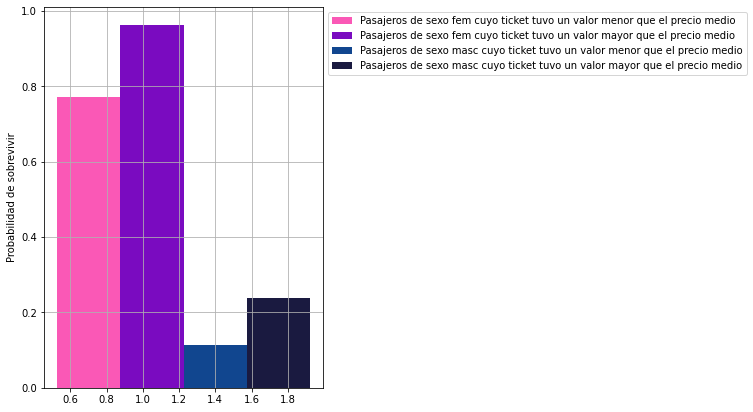

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data_ = {"Pasajeros de sexo fem cuyo ticket tuvo un valor menor que el precio medio": data[0],
         "Pasajeros de sexo fem cuyo ticket tuvo un valor mayor que el precio medio": data[1],
         "Pasajeros de sexo masc cuyo ticket tuvo un valor menor que el precio medio": data[2],
         "Pasajeros de sexo masc cuyo ticket tuvo un valor mayor que el precio medio": data[3]}

names= list(data_.keys())
values = list(data_.values())

fig, ax = plt.subplots(figsize=(5, 7))

x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

print(values[0])

rect1 = ax.bar(2*width, values[0],width, label=names[0], color="#FA58B6")
rect2 = ax.bar(3*width, values[1],width, label=names[1], color="#7A0BC0")
rect3 = ax.bar(4*width, values[2],width, label=names[2], color="#11468F")
rect4 = ax.bar(5*width, values[3],width, label=names[3], color="#1A1A40")

ax.legend(bbox_to_anchor=(1, 1), loc='best')

fig.tight_layout()
plt.ylabel("Probabilidad de sobrevivir")
plt.grid()
plt.show()

In [ ]:
qty_fem = len(X_train[X_train["Sex"] == 0])
qty_mas = len(X_train[X_train["Sex"]== 1])

sex_fem_surv= len(X_train[(X_train["Survived"]==1) & (X_train["Sex"]== 0)])
sex_mas_surv = len(X_train[(X_train["Survived"]==1) & (X_train["Sex"]== 1)])

print("Sobrevivientes de sexo femenino", sex_fem_surv)
print("Sobrevivientes de sexo masculino", sex_mas_surv)

print("Cantidad pasajeros de sexo femenino", qty_fem)
print("Cantidad pasajeros de sexo masculino", qty_mas)

Sobrevivientes de sexo femenino 385
Sobrevivientes de sexo masculino 109
Cantidad pasajeros de sexo femenino 466
Cantidad pasajeros de sexo masculino 842


Podemos concluir que la gran variacion de probabilidades depiendiendo el sexo podria ser debido a que habia casi el doble de pasajeros masculinos que femeninos. Por lo que los pasajeros de sexo masculino teninan menos probabilidad de sobrevivir.

## Aplicando ML a los datos

In [3]:
df_gndr_sub = pd.read_csv(path1).sort_values(by=["PassengerId"])
df_test = pd.read_csv(path2).sort_values(by=["PassengerId"])
df_train = pd.read_csv(path3).sort_values(by=["PassengerId"])

Lo primero a hacer sera limpiar los datos, tratando los missing values y las variables categoricas.

In [4]:
# obtener la lista de variables categoricas
s = (df_train.dtypes == 'object')
object_cols = list(s[s].index)

print(f"Las variables categoricas son: {object_cols}")


Las variables categoricas son: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Tratamos las variables categoricas:

In [6]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

X_train = df_train.copy()
X_valid = df_test.copy()

# Aplicamos el metodo Ordinal encoder ca la columna Sex

X_train[["Sex", "Cabin", "Embarked"]] = ordinal_encoder.fit_transform(X_train[["Sex", "Cabin", "Embarked"]])
X_valid[["Sex", "Cabin", "Embarked"]] = ordinal_encoder.fit_transform(X_valid[["Sex", "Cabin", "Embarked"]])

Podemos observar que si en la columna "Sex" tenemos un 1 => es masculino por lo tanto si tenemos un 0 => es femenino.

Veamos las filas nulas:

In [7]:
# Asi podemos obtener las columnas donde tenemos filas nulas.

cols_with_missing_df_train = [col for col in X_train.columns if X_train[col].isnull().any()]
cols_with_missing_df_valid = [col for col in X_valid.columns if X_valid[col].isnull().any()]

print(f"Las columnas con valores nulos son: {cols_with_missing_df_train}")
print(f"Las columnas con valores nulos son: {cols_with_missing_df_valid}")

X_train.isnull().sum()


Las columnas con valores nulos son: ['Age', 'Cabin', 'Embarked']
Las columnas con valores nulos son: ['Age', 'Fare', 'Cabin']


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
X_valid.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Ahora tratamos los valores nulos.

In [9]:
## Ahora trataremos los missing values con el approach Imputation
from sklearn.impute import SimpleImputer

# Hacemos una copia para no reemplazar valores.
X_train_ = X_train[["Age", "Fare", "Sex", "Cabin", "Embarked"]].copy()
X_valid_ = X_valid[["Age", "Fare", "Sex", "PassengerId", "Cabin", "Embarked"]].copy()

# Reemplazamos los valores nulos que existen en Cabin por un 0.
for row in range(len(X_train_["Cabin"])):
  if pd.isna(X_train_["Cabin"][row]):
    X_train_["Cabin"][row] = 0

# Hacemos lo mismo para la data de validacion
for row in range(len(X_valid_["Cabin"])):
  if pd.isna(X_valid_["Cabin"][row]):
    X_valid_["Cabin"][row] = 0

# Reemplazamos los valores nulos que existen en Embarked por un 0.
for row in range(len(X_train_["Embarked"])):
  if pd.isna(X_train_["Embarked"][row]):
    X_train_["Embarked"][row] = 0
    
my_imputer = SimpleImputer()

imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train_))
imputed_X_valid = pd.DataFrame(my_imputer.fit_transform(X_valid_))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train_.columns
imputed_X_valid.columns = X_valid_.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Podemos observar que los pasajeros los cuales no tenian edad se ha asignado un numero deacuerdo a las edades del resto de los pasajeros. 
Ahora deberiamos redondear deste valor ya que no es posible tener 30.27 anos

In [ ]:
imputed_X_valid[imputed_X_valid["PassengerId"] == 1309]	

,Age,Fare,Sex,PassengerId,Cabin,Embarked
417,30.27259,22.3583,1.0,1309.0,0.0,0.0


In [12]:
imputed_X_valid["Age"] = np.round(imputed_X_valid["Age"])

Declaramos el modelo con el que vamos a trabajar, lo entrenaremos para luego realizar una prediccion con la data de validacion.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Define model
titanicDeath = RandomForestClassifier(random_state=1)

y = df_train.Survived
X = imputed_X_train[["Age", "Sex", "Fare", "Cabin", "Embarked"]]

# Fit model
titanicDeath.fit(X, y)

# get predicted deaths on validation data
val_predictions = titanicDeath.predict(imputed_X_valid[["Age", "Sex", "Fare", "Cabin", "Embarked"]])



Ahora vamos a ver que tan bueno es nuestro modelo.

In [15]:
# al no tener la columna de survived en la data de validacion, sera necesario hacer un join con el dataframe que contiene esta informacion
# hacemos esto para luego poder comparar con el valor que predijo el modelo

join = df_gndr_sub.merge(imputed_X_valid, how="left", on="PassengerId")

In [16]:
# hacemos esto para verificar que el orden en el cual
print(join)
print(np.array_equal(np.array(imputed_X_valid["PassengerId"]), np.array(join["PassengerId"])))

     PassengerId  Survived   Age      Fare  Sex  Cabin  Embarked
0            892         0  34.0    7.8292  1.0    0.0       1.0
1            893         1  47.0    7.0000  0.0    0.0       2.0
2            894         0  62.0    9.6875  1.0    0.0       1.0
3            895         0  27.0    8.6625  1.0    0.0       2.0
4            896         1  22.0   12.2875  0.0    0.0       2.0
..           ...       ...   ...       ...  ...    ...       ...
413         1305         0  30.0    8.0500  1.0    0.0       2.0
414         1306         1  39.0  108.9000  0.0   22.0       0.0
415         1307         0  38.0    7.2500  1.0    0.0       2.0
416         1308         0  30.0    8.0500  1.0    0.0       2.0
417         1309         0  30.0   22.3583  1.0    0.0       0.0

[418 rows x 7 columns]
True


Ahora para ver que tan bueno es el modelo lo que haremos sera lo sig: Vamos a agarrar nuestra data de validacion que previamente hemos anadido la variable survived, y ahora vamos a crear una columna que contega el valor de nuestras predicciones.

Luego restaremos ambas columnas y el resultado sera la cantidad de errores.

In [17]:
join["Survived_p"] = val_predictions
join

,PassengerId,Survived,Age,Fare,Sex,Cabin,Embarked,Survived_p
0,892,0,34.0,7.8292,1.0,0.0,1.0,0
1,893,1,47.0,7.0000,0.0,0.0,2.0,0
2,894,0,62.0,9.6875,1.0,0.0,1.0,0
3,895,0,27.0,8.6625,1.0,0.0,2.0,1
4,896,1,22.0,12.2875,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...
413,1305,0,30.0,8.0500,1.0,0.0,2.0,0
414,1306,1,39.0,108.9000,0.0,22.0,0.0,1
415,1307,0,38.0,7.2500,1.0,0.0,2.0,0
416,1308,0,30.0,8.0500,1.0,0.0,2.0,0


In [19]:
# veamos cuantos errores tuvimos
survived = join["Survived"]
survived_pred = join["Survived_p"]
res = survived - survived_pred

# ahora contamos los valores != 0 que tenga el resultado y estos seran los errores que tuvimos
print(f"Tengo un total de: {np.count_nonzero(res)} errores")

Tengo un total de: 68 errores


Por lo que tenemos un miss-rate de 68/418 = 16.2% aprox ie que contamos con acierto del 83.8